In [1]:
# In this notebook the coordinate system is z-up and cameras look towards +z
%load_ext autoreload
%autoreload 2

import colorsys
import random
import os
import pickle
import sys
sys.path.insert(1, '/home/cem/Desktop/ov-workspace/src')

import numpy as np
import matplotlib.pyplot as plt
import PIL
import open3d as o3d
import tensorflow as tf

from skimage import color
from imps.sensors import OVCamera
from imps.pc_utils import from_mv_rgb_depth 

physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

DATA_DIR = '/home/cem/Desktop/ov-workspace/data/ov-v4/'

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


2021-10-06 10:41:26.854274: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-06 10:41:28.098183: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-06 10:41:28.098715: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-06 10:41:28.099242: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-06 10:41:28.099565: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: Quadro RTX 3000 computeCapability: 7.5
coreClock: 1.38GHz coreCount: 30 deviceMemorySize: 5.79GiB deviceMemoryBandwidth: 312.97GiB/s
2021-10-06 10:41:28.099591: I tensorflow/stream_executor/platform/default/dso

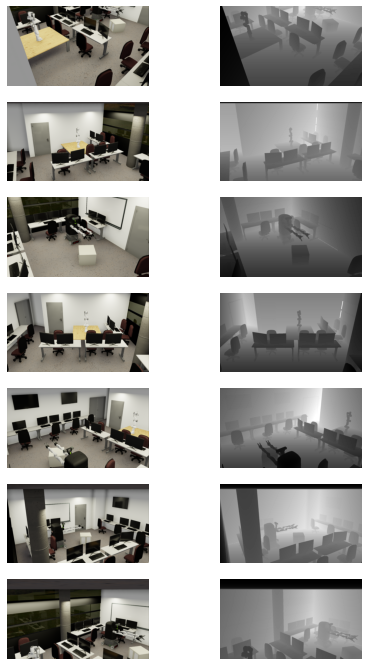

In [2]:
frames = range(7)
f, axs = plt.subplots(7, 2, figsize=(7, 12))

for f in frames:
    f_rgb_dir = os.path.join(DATA_DIR, f'images/frame.{f}.png')
    f_depth_dir = os.path.join(DATA_DIR, f'depth/frame.{f}.depthLinear.npy')
    
    color_raw = np.array(o3d.io.read_image(f_rgb_dir))
    depth_raw = np.array(o3d.geometry.Image(np.load(f_depth_dir).squeeze()))
    
    depth_raw = np.clip(depth_raw, 0, 10)
    depth_raw = (depth_raw - depth_raw.min()) / (depth_raw.max() - depth_raw.min())
    
    axs[f, 0].imshow(color_raw)
    axs[f, 1].imshow(depth_raw, cmap='gray')
    axs[f, 0].axis('off')
    axs[f, 1].axis('off')

In [3]:
room_pcd = from_mv_rgb_depth(DATA_DIR, crop_height=2.99)
o3d.visualization.draw_geometries([room_pcd])

In [5]:
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(room_pcd, voxel_size=0.025)

# Semantic Segmentation with RandLA-Net

In [27]:
# https://github.com/isl-org/Open3D-ML/tree/master/ml3d/configs

import open3d.ml as _ml3d
import open3d.ml.tf as ml3d

cfg_file = "../configs/randlanet_s3dis.yml"
cfg = _ml3d.utils.Config.load_from_file(cfg_file)

ckpt_path = "../logs/randlanet/ckpt-92"

model = ml3d.models.RandLANet(**cfg.model, batchNorm=False)
pipeline = ml3d.pipelines.SemanticSegmentation(model)
pipeline.load_ckpt(ckpt_path)

2021-10-05 16:32:23.182050: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-05 16:32:23.236758: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-05 16:32:23.236889: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-05 16:32:23.237207: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: Quadro RTX 3000 computeCapability: 7.5
coreClock: 1.38GHz coreCount: 30 deviceMemorySize: 5.79GiB deviceMemoryBandwidth: 312.97GiB/s
2021-10-05 16:32:23.237267: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-05 16:32:23.237280: I tensorflow/stream_executor/platform/defaul

In [28]:
data = {
    'point': np.asarray(room_pcd.points, dtype=np.float32),
    'feat': np.asarray(room_pcd.colors, dtype=np.float32),
    'label': None
}

prediction = pipeline.run_inference(data)

INFO - 2021-10-05 16:32:34,629 - semantic_segmentation - running inference
  0%|                                                                         | 0/101363 [00:00<?, ?it/s]2021-10-05 16:32:38.274720: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-05 16:32:38.760542: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-10-05 16:32:38.785605: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
WARNING - 2021-10-05 16:32:41,519 - deprecation - From %s: %s (from %s) is deprecated and will be removed %s.
Instructions for updating:
%s
100%|█████████████████████████████████████████████████████████| 101363/101363 [00:05<00:00, 19068.17it/s]


In [34]:
room_pcd.colors = o3d.utility.Vector3dVector(
    color.label2rgb(prediction['predict_labels'], bg_label=0))

In [ ]:
o3d.visualization.draw_geometries([room_pcd])

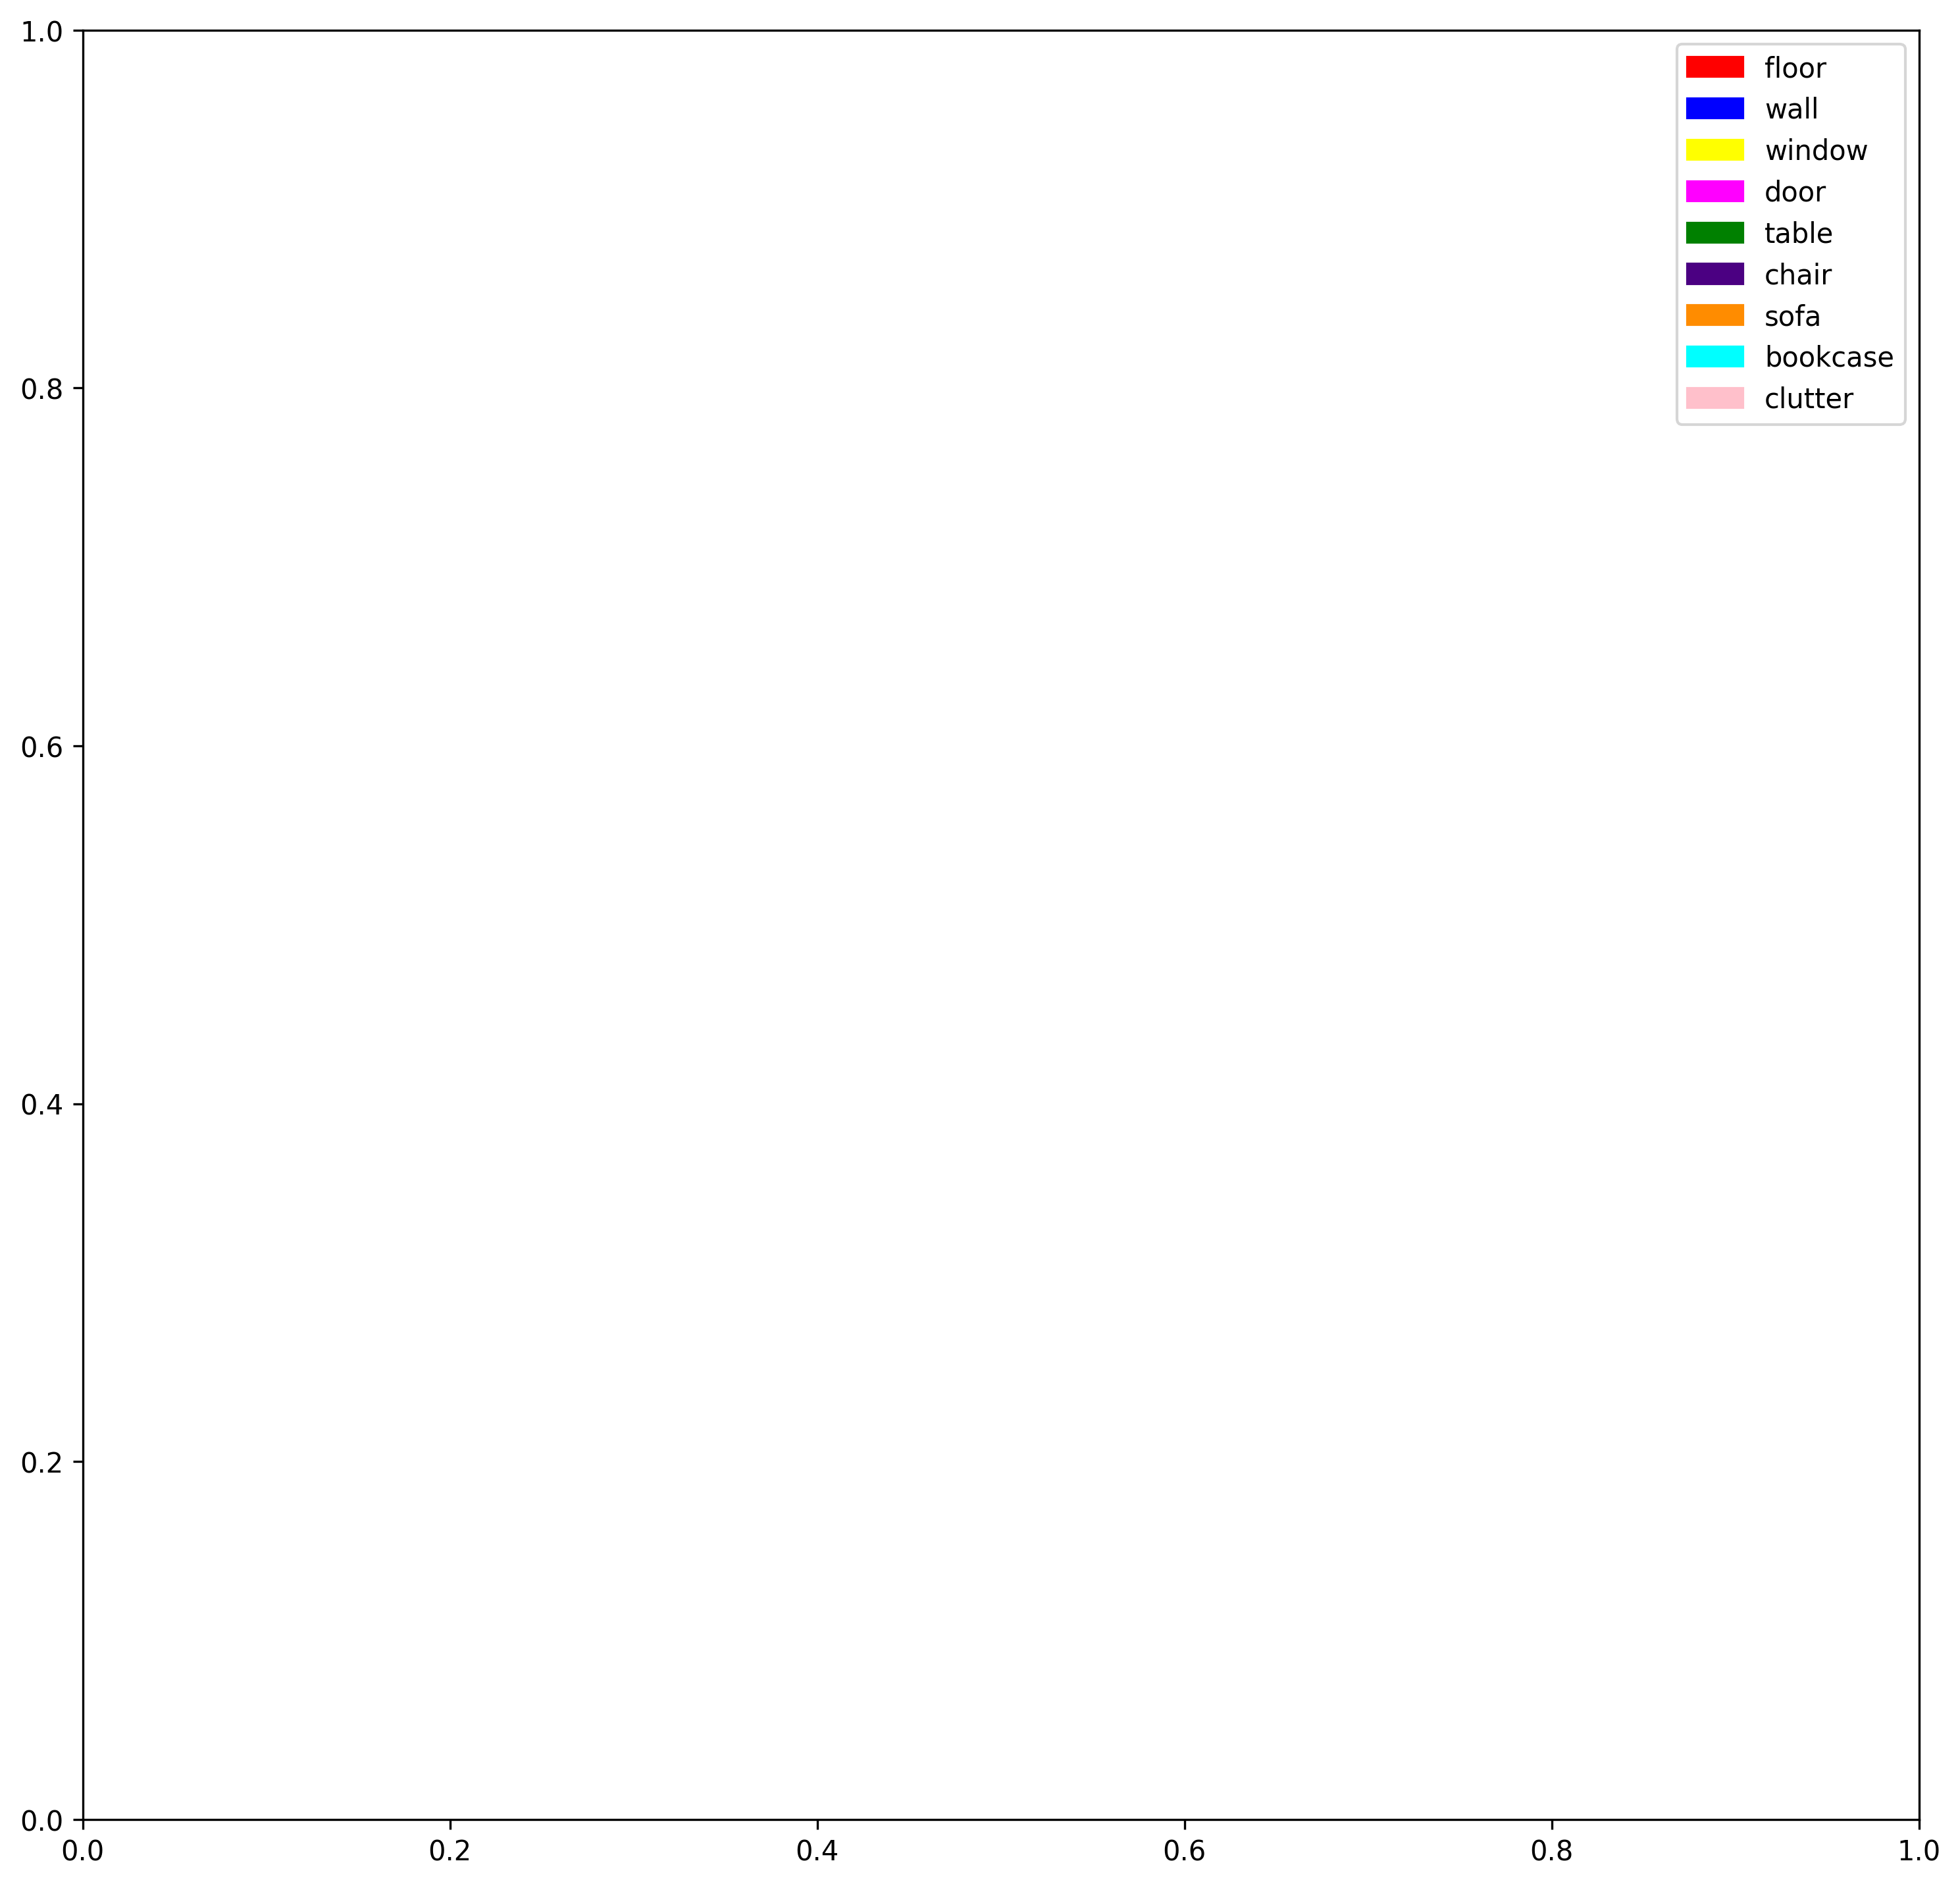

In [44]:
import matplotlib.patches as mpatches

label_to_names = {
            0: 'ceiling',
            1: 'floor',
            2: 'wall',
            3: 'beam',
            4: 'column',
            5: 'window',
            6: 'door',
            7: 'table',
            8: 'chair',
            9: 'sofa',
            10: 'bookcase',
            11: 'board',
            12: 'clutter'
}

unique_labels = np.unique(prediction['predict_labels'])
patches = []
for l, c in zip(unique_labels, color.label2rgb(unique_labels, bg_label=0)):
    patches.append(mpatches.Patch(color=c, label=label_to_names[l]))

f = plt.figure(figsize=(12, 12), dpi=300)
plt.legend(handles=patches)